In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [213]:
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [214]:
# checking for null values
print(f"{df.isna().sum()}\n")

# checking for unique values
print(f"{df.nunique()}\n")

print(df.shape)

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Age                50
Sex                 2
ChestPainType       4
RestingBP          67
Cholesterol       222
FastingBS           2
RestingECG          3
MaxHR             119
ExerciseAngina      2
Oldpeak            53
ST_Slope            3
HeartDisease        2
dtype: int64

(918, 12)


In [215]:
# feature groups
ohe = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina']
oe = ['ST_Slope']
stdScaler = ['Oldpeak', 'MaxHR', 'Cholesterol', 'RestingBP']            # scaling the numerical data

# using column transformers
trf = ColumnTransformer([
    ('t1', OneHotEncoder(sparse_output=False, drop='first'), ohe),
    ('t5', OrdinalEncoder(categories=[['Up', 'Flat', 'Down']]), oe),
    ('t6', StandardScaler(), stdScaler)
], remainder='passthrough')


"""
 ---- WHAT IF oe WOULD HAVE HOLD MORE THAN ONE COLUMNS ---- 


oe = ['ST_Slope', 'AnotherCol', 'ThirdCol']

trf = ColumnTransformer([
    ('t1', OneHotEncoder(sparse_output=False, drop='first'), ohe),
    ('t5', OrdinalEncoder(categories=[
        ['Up', 'Flat', 'Down'],      # for ST_Slope
        ['Low', 'Med', 'High'],      # for AnotherCol
        ['Bad', 'Avg', 'Good']       # for ThirdCol
    ]), oe),
    ('t6', StandardScaler(), stdScaler)
], remainder='passthrough')

"""

# splitting the data
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['HeartDisease']), df['HeartDisease'], test_size=0.2, random_state=0)

# copying x_train into another variable to store column names
train_cols = x_train.copy()

# encoding and scaling the data
x_train = trf.fit_transform(x_train)
x_test = trf.transform(x_test)
print(f"SHAPE OF x_train : {x_train.shape}")


# storing all the column names in a variable
cols = (
    list(trf.named_transformers_['t1'].get_feature_names_out(ohe))
    + oe
    + stdScaler
    + [c for c in train_cols.columns if c not in (ohe + oe + stdScaler)]
)


"""
 ---- IMP ----

You can only build `cols` after `trf.fit_transform()` because the transformers do not know the final output columns before fitting. 
OneHotEncoder and OrdinalEncoder create new columns based on learned categories. These new column names are only available after fit. 
So if you try to access `trf.named_transformers_` or `get_feature_names_out()` before fitting, it will fail. 
First fit → transformers learn categories → new columns exist → then you can build the final column list.

"""

# convert back to DataFrame
x_train = pd.DataFrame(x_train, columns=cols)
x_test = pd.DataFrame(x_test, columns=cols)

reg = LogisticRegression(max_iter=2000)     # just remove max_iter and you will see the difference
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

print(f"ACCURACY SCORE : {np.round(accuracy_score(y_test, y_pred)*100)} %")

SHAPE OF x_train : (734, 14)
ACCURACY SCORE : 84.0 %


In [216]:
"""
 ---- CAN I WRITE THIS ---- 
 cols = (
    list(trf.named_transformers_['t1'].get_feature_names_out(ohe))
    + list(trf.named_transformers_['t2'].get_feature_names_out(oe))
    + list(trf.named_transformers_['t3'].get_feature_names_out(stdScaler))
    + [c for c in train_cols.columns if c not in (ohe + oe + stdScaler)]
)


OneHotEncoder creates multiple new columns for each category. So 
get_feature_names_out is useful because it returns the expanded column names.

OrdinalEncoder does not create extra columns. It only replaces each category
with an integer. Number of columns stays the same. So 
get_feature_names_out returns the same original column names. That makes 
calling it unnecessary.

StandardScaler also does not create or remove columns. It only scales 
numeric values. So its column names also stay the same.

Therefore:
- Use get_feature_names_out only for OneHotEncoder.
- For OrdinalEncoder and StandardScaler, just reuse the original column names.



"""

"\n ---- CAN I WRITE THIS ---- \n cols = (\n    list(trf.named_transformers_['t1'].get_feature_names_out(ohe))\n    + list(trf.named_transformers_['t2'].get_feature_names_out(oe))\n    + list(trf.named_transformers_['t3'].get_feature_names_out(stdScaler))\n    + [c for c in train_cols.columns if c not in (ohe + oe + stdScaler)]\n)\n\n\nOneHotEncoder creates multiple new columns for each category. So \nget_feature_names_out is useful because it returns the expanded column names.\n\nOrdinalEncoder does not create extra columns. It only replaces each category\nwith an integer. Number of columns stays the same. So \nget_feature_names_out returns the same original column names. That makes \ncalling it unnecessary.\n\nStandardScaler also does not create or remove columns. It only scales \nnumeric values. So its column names also stay the same.\n\nTherefore:\n- Use get_feature_names_out only for OneHotEncoder.\n- For OrdinalEncoder and StandardScaler, just reuse the original column names.\n\n

## Writing the same code again using Pipelines

By using pipelines here we will realize how easier it becomes to write codes, rather than manually encoding and scaling every column through 'fit_train'

In [221]:
ohe = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina']
oe = ['ST_Slope']
stdScaler = ['Oldpeak', 'MaxHR', 'Cholesterol', 'RestingBP']

# making a transformer
trf = ColumnTransformer([
    ('t1', OneHotEncoder(sparse_output=False, drop='first'), ohe),
    ('t5', OrdinalEncoder(categories=[['Up', 'Flat', 'Down']]), oe),
    ('t6', StandardScaler(), stdScaler)
], remainder='passthrough')

# making a pipeline
pipe = Pipeline([
    ('trf', trf),
    ('model', LogisticRegression(max_iter=2000))
])

# splitting the data
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns=['HeartDisease']), df['HeartDisease'], test_size=0.2, random_state=0)

# making prediction
pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)
print(f"ACCURACY SCORE : {np.round(accuracy_score(y_test, y_pred)*100)} %")



ACCURACY SCORE : 84.0 %


In [222]:
x_train

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
378,70,M,ASY,140,0,1,Normal,157,Y,2.0,Flat
356,46,M,ASY,115,0,0,Normal,113,Y,1.5,Flat
738,65,F,NAP,160,360,0,LVH,151,N,0.8,Up
85,66,M,ASY,140,139,0,Normal,94,Y,1.0,Flat
427,59,M,ASY,140,0,0,ST,117,Y,1.0,Flat
...,...,...,...,...,...,...,...,...,...,...,...
835,54,M,ASY,110,239,0,Normal,126,Y,2.8,Flat
192,48,M,ATA,130,245,0,Normal,160,N,0.0,Up
629,57,F,ASY,128,303,0,LVH,159,N,0.0,Up
559,64,M,ASY,134,273,0,Normal,102,Y,4.0,Down


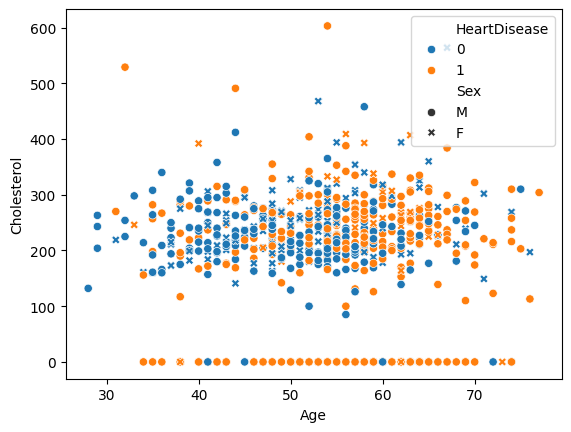

In [223]:
x_train_concat = pd.concat([x_train, y_train], axis=1)

sns.scatterplot(x_train_concat, x='Age', y='Cholesterol', hue='HeartDisease', style='Sex')
plt.show()

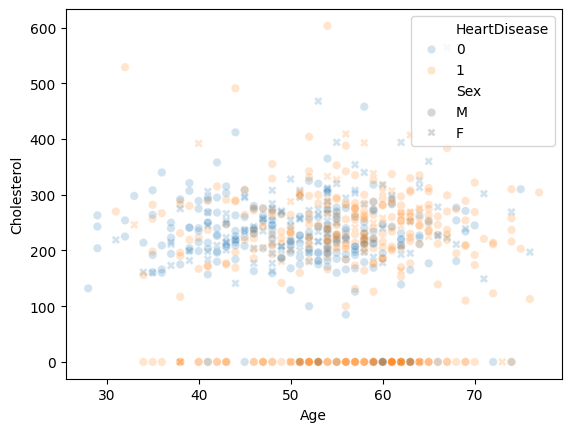

In [225]:
sns.scatterplot(x_train_concat, x='Age', y='Cholesterol', hue='HeartDisease', style='Sex', alpha=0.2)
plt.show()

In [ ]:
# transform x_train and x_test manually to get DataFrame with column names
x_train_transformed = pipe.named_steps['trf'].transform(x_train)
x_test_transformed = pipe.named_steps['trf'].transform(x_test)

# get column names
cols = list(pipe.named_steps['trf'].named_transformers_['t1'].get_feature_names_out(ohe)) \
        + oe \
        + stdScaler \
        + [c for c in x_train.columns if c not in (ohe + oe + stdScaler)]

# convert to DataFrame
x_train_df = pd.DataFrame(x_train_transformed, columns=cols)
x_test_df = pd.DataFrame(x_test_transformed, columns=cols)

x_train_df

,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope,Oldpeak,MaxHR,Cholesterol,RestingBP,Age,FastingBS
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.055374,0.793140,-1.850065,0.403985,70.0,1.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.577847,-0.924506,-1.850065,-0.950506,46.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.090691,0.558916,1.498941,1.487578,65.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.100320,-1.666216,-0.556976,0.403985,66.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.100320,-0.768356,-1.850065,0.403985,59.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.819417,-0.417019,0.373303,-1.221404,54.0,0.0
730,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.854734,0.910252,0.429120,-0.137811,48.0,0.0
731,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.854734,0.871215,0.968682,-0.246171,57.0,0.0
732,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,2.965482,-1.353917,0.689598,0.078907,64.0,0.0


In [ ]:

"""
  ---- WHY NO USE OF COLUMNS ----

In the pipeline, we do not need to manually construct `cols` because the ColumnTransformer inside the pipeline handles all transformations internally. 
The model receives the transformed array directly, and we never convert it back to a DataFrame for the model to work. 
`cols` is only needed if you want a DataFrame with proper column names for inspection, analysis, or exporting. 
For fitting and predicting with the pipeline, the numeric array output from the transformer is sufficient.

_______________________________________________________________________________________________________________________________________________________________


so when i use pipeline, whenever i call this pipe.fit(x_train, y_train) or this pipe.predict(x_test), 
i dont need to manually use encode or scale data using fit_transform. 

Whenever pipe is called it automatically first scale and encode the x_train columns (which will not be applied to y_train) and 
after doing these then it will use logistic regression to find the best possible line.

Same will be applied for x_test

"""

'\n  ---- WHY NO USE OF COLUMNS ----\n\nIn the pipeline, we do not need to manually construct `cols` because the ColumnTransformer inside the pipeline handles all transformations internally. \nThe model receives the transformed array directly, and we never convert it back to a DataFrame for the model to work. \n`cols` is only needed if you want a DataFrame with proper column names for inspection, analysis, or exporting. \nFor fitting and predicting with the pipeline, the numeric array output from the transformer is sufficient.\n\n_______________________________________________________________________________________________________________________________________________________________\n\n\nso when i use pipeline, whenever i call this pipe.fit(x_train, y_train) or this pipe.predict(x_test), \ni dont need to manually use encode or scale data using fit_transform. \n\nWhenever pipe is called it automatically first scale and encode the x_train columns (which will not be applied to y_train

## Plotting various diagrams

In [ ]:
scale = StandardScaler()
cols = ['Age', 'Oldpeak', 'MaxHR', 'Cholesterol', 'RestingBP']

# scaling the columns and replacing themselves with the scaled data
x_train[cols] = scale.fit_transform(x_train[cols])

# combining x_train and y_train
x_train = pd.concat([x_train, y_train], axis=1)

x_train


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
378,1.753540,M,ASY,0.403985,-1.850065,1,Normal,0.793140,Y,1.055374,Flat,1
356,-0.817871,M,ASY,-0.950506,-1.850065,0,Normal,-0.924506,Y,0.577847,Flat,1
738,1.217829,F,NAP,1.487578,1.498941,0,LVH,0.558916,N,-0.090691,Up,0
85,1.324972,M,ASY,0.403985,-0.556976,0,Normal,-1.666216,Y,0.100320,Flat,1
427,0.574977,M,ASY,0.403985,-1.850065,0,ST,-0.768356,Y,0.100320,Flat,1
...,...,...,...,...,...,...,...,...,...,...,...,...
835,0.039266,M,ASY,-1.221404,0.373303,0,Normal,-0.417019,Y,1.819417,Flat,1
192,-0.603587,M,ATA,-0.137811,0.429120,0,Normal,0.910252,N,-0.854734,Up,0
629,0.360692,F,ASY,-0.246171,0.968682,0,LVH,0.871215,N,-0.854734,Up,0
559,1.110687,M,ASY,0.078907,0.689598,0,Normal,-1.353917,Y,2.965482,Down,1


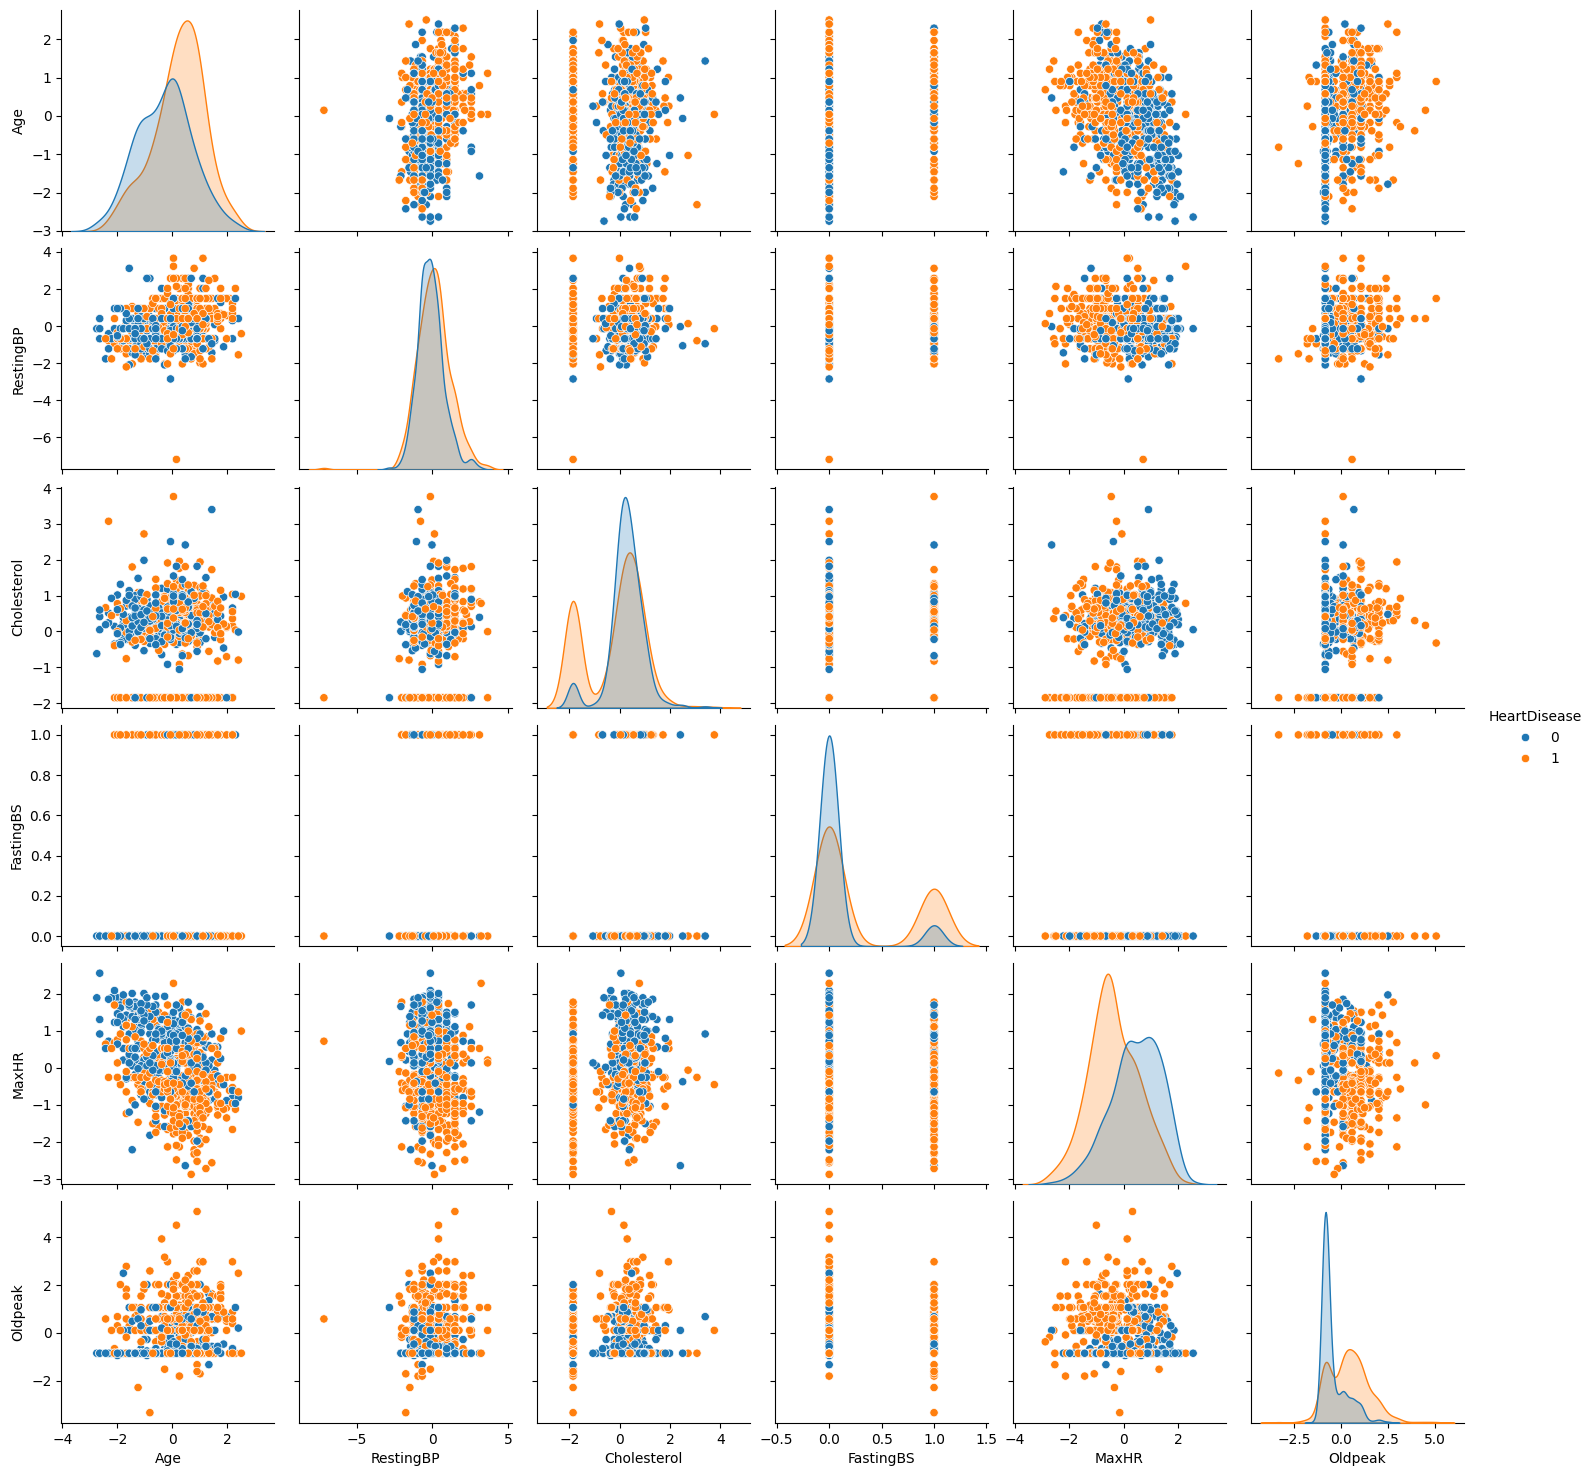

In [ ]:
sns.pairplot(x_train, hue='HeartDisease')       # the diagram below represents the graph of the scaled datas
plt.show()

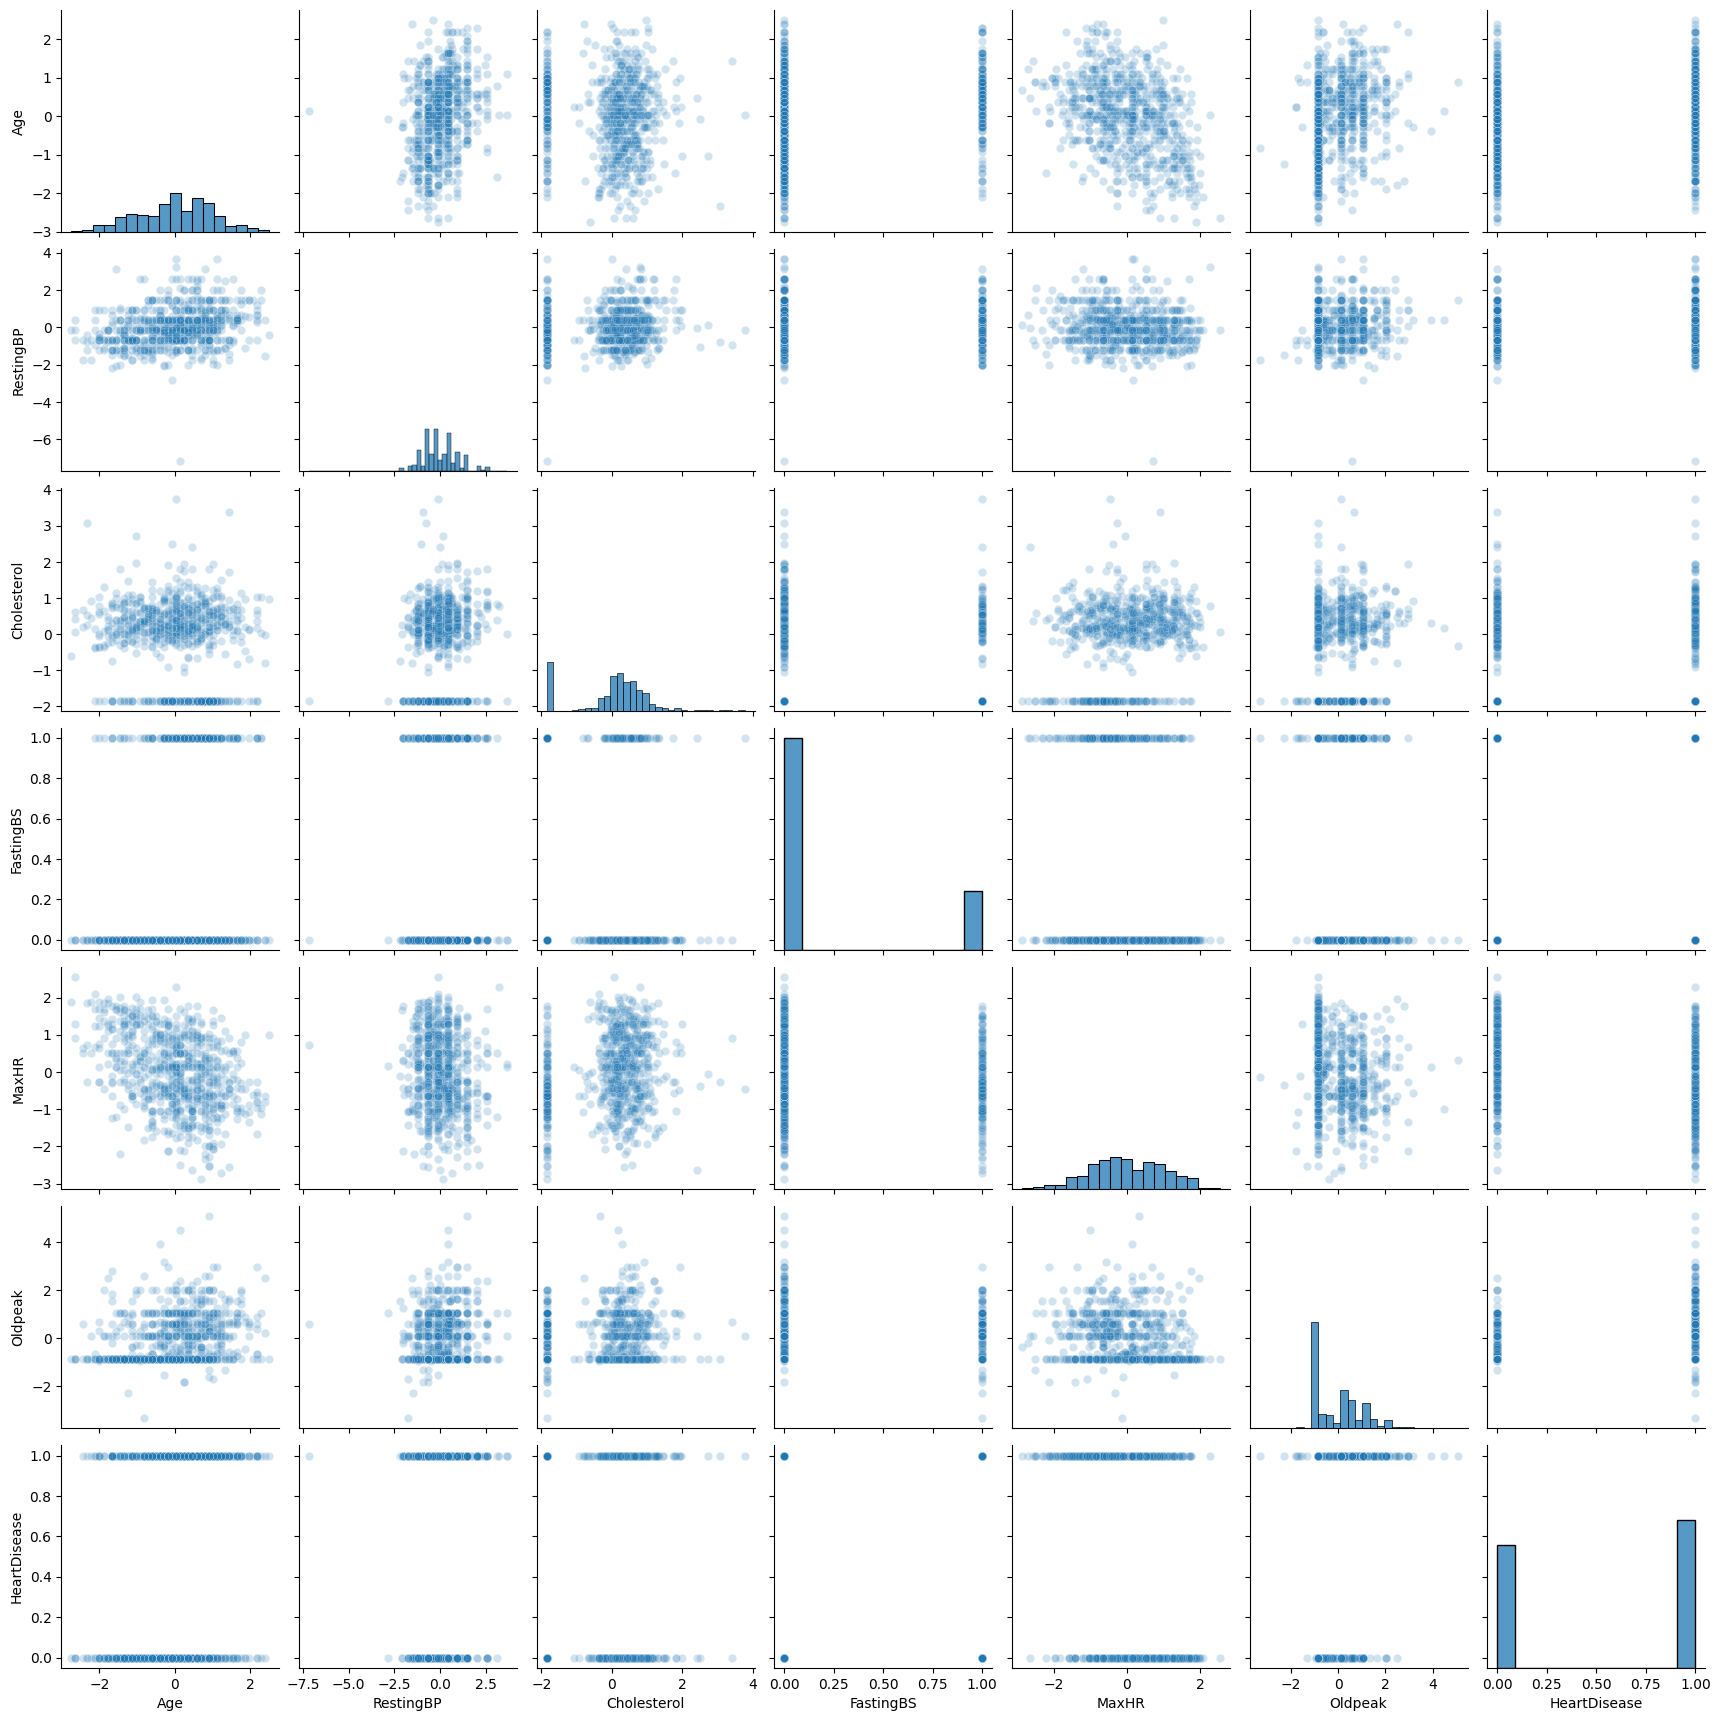

In [ ]:
sns.pairplot(x_train, plot_kws={'alpha': 0.2})      
# plot_kws --- contrls the marker transparency, in other words it is used to show the density of the data
# change the numeric value in the plot_kws to change the transparency of the data
plt.show()